In [51]:
import os
os.environ["KAGGLE_USERNAME"] = "filipedanielmota"
os.environ["KAGGLE_KEY"] = "2314b79815678fef0b557ec736c2a3b3"

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import  matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import pandas as pd
import os

# Baixar a última versão do dataset
path = kagglehub.dataset_download("adampq/pokemon-tcg-all-cards-1999-2023")

# Especificar o nome do arquivo dentro do diretório extraído
file_name = "pokemon-tcg-data-master 1999-2023.csv"  # Substitua pelo nome correto do arquivo
file_path = os.path.join(path, file_name)

# Carregar o arquivo como DataFrame do Pandas
df = pd.read_csv(file_path)

print("Primeiros 5 registros:")
print(df.head())

Primeiros 5 registros:
        id   set series publisher generation release_date           artist  \
0  base1-1  Base   Base      WOTC      First     1/9/1999     Ken Sugimori   
1  base1-2  Base   Base      WOTC      First     1/9/1999     Ken Sugimori   
2  base1-3  Base   Base      WOTC      First     1/9/1999     Ken Sugimori   
3  base1-4  Base   Base      WOTC      First     1/9/1999  Mitsuhiro Arita   
4  base1-5  Base   Base      WOTC      First     1/9/1999     Ken Sugimori   

        name set_num          types  ...  \
0   Alakazam       1    ['Psychic']  ...   
1  Blastoise       2      ['Water']  ...   
2    Chansey       3  ['Colorless']  ...   
3  Charizard       4       ['Fire']  ...   
4   Clefairy       5  ['Colorless']  ...   

                               retreatCost convertedRetreatCost     rarity  \
0  ['Colorless', 'Colorless', 'Colorless']                  3.0  Rare Holo   
1  ['Colorless', 'Colorless', 'Colorless']                  3.0  Rare Holo   
2        

In [53]:
# Remover as colunas especificadas
columns_to_remove = [
    "id", "set", "series", "publisher", "release_date", "artist", "envolvesFrom", "envolvesTo", 
    "name", "set_num", "flavorText", "regulationMark", "ancientTrait"
]
df = df.drop(columns=columns_to_remove)


KeyError: "['id', 'set', 'series', 'publisher', 'release_date', 'artist', 'name', 'set_num', 'flavorText', 'regulationMark', 'ancientTrait'] not found in axis"

In [54]:
print("Colunas restantes:")
print(df.head)

Colunas restantes:
<bound method NDFrame.head of       generation          types supertype                    subtypes level  \
0          First    ['Psychic']   Pokémon                 ['Stage 2']    42   
1          First      ['Water']   Pokémon                 ['Stage 2']    52   
2          First  ['Colorless']   Pokémon                   ['Basic']    55   
3          First       ['Fire']   Pokémon                 ['Stage 2']    76   
4          First  ['Colorless']   Pokémon                   ['Basic']    14   
...          ...            ...       ...                         ...   ...   
17167      Ninth   ['Darkness']   Pokémon  ['Basic', 'ex', 'Ancient']   NaN   
17168      Ninth            NaN   Trainer                 ['Stadium']   NaN   
17169      Ninth            NaN   Trainer                    ['Item']   NaN   
17170      Ninth            NaN   Trainer            ['Pokémon Tool']   NaN   
17171      Ninth            NaN    Energy                 ['Special']   NaN   

  

In [45]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17172 entries, 0 to 17171
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   generation              17172 non-null  object 
 1   types                   14500 non-null  object 
 2   supertype               17172 non-null  object 
 3   subtypes                16998 non-null  object 
 4   level                   2404 non-null   object 
 5   hp                      14536 non-null  float64
 6   evolvesFrom             6165 non-null   object 
 7   evolvesTo               5790 non-null   object 
 8   abilities               3428 non-null   object 
 9   attacks                 14509 non-null  object 
 10  weaknesses              14094 non-null  object 
 11  retreatCost             13678 non-null  object 
 12  convertedRetreatCost    13678 non-null  float64
 13  rarity                  16877 non-null  object 
 14  nationalPokedexNumbers  14398 non-null

C:\Users\FIOT\AppData\Local\Temp\ipykernel_17364\2899051062.py:3: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\FIOT\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


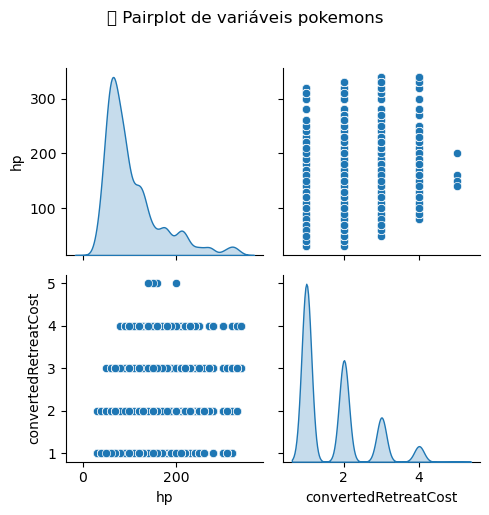

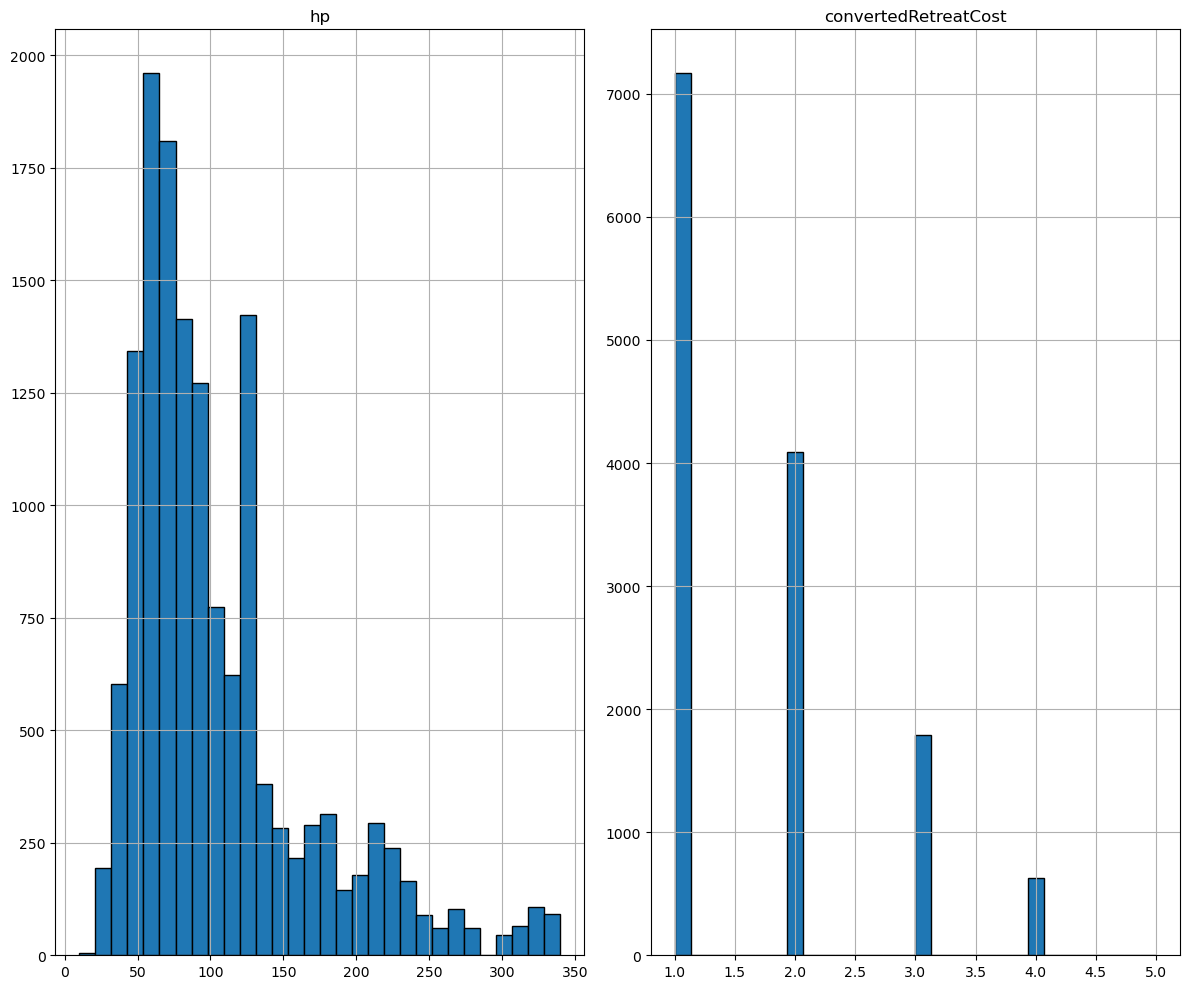

In [41]:
sns.pairplot(df[['generation','types','supertype','subtypes','level','hp','evolvesTo','evolvesFrom','abilities','attacks','weaknesses','retreatCost','convertedRetreatCost','rarity','nationalPokedexNumbers','legalities','resistances','rules']], diag_kind="kde")
plt.suptitle("🔍 Pairplot de variáveis pokemons", y=1.02)
plt.tight_layout()
plt.show()

df.hist(bins=30, figsize=(12, 10), edgecolor='black')
plt.tight_layout()
plt.show()